In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Import Necessary Modules

import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tqdm import tqdm
from keras.utils import to_categorical
from keras import backend as K

%tensorflow_version 2.x
import tensorflow as tf
from tensorflow import keras

In [3]:
def create_dataset(image_path, mask_path):
  K.clear_session()
  X = np.zeros((5000,128,128,3))
  Y = np.zeros((5000,128*128,2))
  for i in tqdm(range(5000)):
    try:
      img = Image.open(image_path + "{0:0=5d}".format(i) + '.jpg')
      img_arr = np.array(img)
      img_arr = tf.cast(img_arr, tf.float32) / 255.0
      X[i] = img_arr
      mask = Image.open(mask_path + "{0:0=5d}".format(i) + '.png').convert('L')
      mask_arr = to_categorical(np.array(mask).reshape(128*128))
      mask_arr = tf.cast(mask_arr, tf.float32)
      Y[i] = mask_arr
    except:
      pass
  X_prep = X[~(X==0).all(axis=(1,2,3))]
  Y_prep = Y[~(Y==0).all(axis=(1,2))]
  print("Number of examples:", Y_prep.shape[0]+1)
  return X_prep, Y_prep

In [4]:
X, Y = create_dataset('/content/drive/My Drive/ML4VA/SegNet_Model/data/images/', '/content/drive/My Drive/ML4VA/SegNet_Model/data/masks/')

100%|██████████| 5000/5000 [47:50<00:00,  1.74it/s]


Number of examples: 4692


In [5]:
X_train = X[:4000]
y_train = Y[:4000]
X_val = X[4000:]
y_val = Y[4000:]
m_examples = X.shape[0]
m_train = X_train.shape[0]
m_val = X_val.shape[0]

In [6]:
from keras.layers import Input, BatchNormalization, Conv2D, UpSampling2D, Reshape, Activation
from keras.models import Model
from keras.backend import clear_session

img_height = 128
img_width = 128

clear_session()
kernel = 3
pool_size = 2
kernel_size = 64

input_shape = Input(shape=(img_height,img_width,3))
model = keras.applications.ResNet152V2(weights="imagenet", include_top=False, input_tensor=input_shape, pooling='avg')

# Decoder Layers

# Block 1
o = UpSampling2D(size=(pool_size, pool_size), data_format='channels_last')(model.layers[-2].output)
o = Conv2D(kernel_size*8, (kernel, kernel), padding='same', activation='relu', data_format='channels_last', kernel_initializer='he_normal')(o)
o = BatchNormalization()(o)

# Block 2
o = UpSampling2D(size=(pool_size, pool_size), data_format='channels_last')(o)
o = Conv2D(kernel_size*4, (kernel, kernel), padding='same', activation='relu', data_format='channels_last', kernel_initializer='he_normal')(o)
o = BatchNormalization()(o)
o = Conv2D(kernel_size*4, (kernel, kernel), padding='same', activation='relu', data_format='channels_last', kernel_initializer='he_normal')(o)
o = BatchNormalization()(o)


# Block 3
o = UpSampling2D(size=(pool_size, pool_size), data_format='channels_last')(o)
o = Conv2D(kernel_size*2, (kernel, kernel), padding='same', activation='relu', data_format='channels_last', kernel_initializer='he_normal')(o)
o = BatchNormalization()(o)
o = Conv2D(kernel_size*2, (kernel, kernel), padding='same', activation='relu', data_format='channels_last', kernel_initializer='he_normal')(o)
o = BatchNormalization()(o)


# Block 4
o = UpSampling2D(size=(pool_size, pool_size), data_format='channels_last')(o)
o = Conv2D(kernel_size*2, (kernel, kernel), padding='same', activation='relu', data_format='channels_last', kernel_initializer='he_normal')(o)
o = BatchNormalization()(o)
o = Conv2D(kernel_size*2, (kernel, kernel), padding='same', activation='relu', data_format='channels_last', kernel_initializer='he_normal')(o)
o = BatchNormalization()(o)


# Block 5
o = UpSampling2D(size=(pool_size, pool_size), data_format='channels_last')(o)
o = Conv2D(kernel_size, (kernel, kernel), padding='same', activation='relu', data_format='channels_last', kernel_initializer='he_normal')(o)
o = BatchNormalization()(o)
o = Conv2D(kernel_size, (kernel, kernel), padding='same', activation='relu', data_format='channels_last', kernel_initializer='he_normal')(o)
o = BatchNormalization()(o)

# Output Block
o = Conv2D(2, (kernel, kernel), padding='same', activation='relu', data_format='channels_last', kernel_initializer='he_normal')(o)
o = Reshape((128*128,2))(o)
o = Activation('softmax')(o)


model = Model(inputs=model.inputs, outputs=o)

model.compile(optimizer='adam',
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

model.summary()

234553344/234545216 [==============================] - 3s 0us/step
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 134, 134, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 64, 64, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 66, 66, 64)   0           conv1_conv[0][0]                 
____________________

In [7]:
# Create checkpoint to store model with best performance
from keras.callbacks import ModelCheckpoint

checkpoint_path = '/content/drive/My Drive/ML4VA/SegNet_Model/model_checkpoints/best_weights.h5'
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', verbose=0, save_best_only=True, mode='max', save_weights_only=True)


In [20]:
model_history = model.fit(X_train, y_train, epochs=25, validation_data= (X_val, y_val), callbacks=[checkpoint])

Epoch 1/25
125/125 [==============================] - 137s 1s/step - loss: 0.5704 - accuracy: 0.6907 - val_loss: 2.1093 - val_accuracy: 0.5537
Epoch 2/25
125/125 [==============================] - 136s 1s/step - loss: 0.4744 - accuracy: 0.7708 - val_loss: 1.2666 - val_accuracy: 0.5797
Epoch 3/25
125/125 [==============================] - 136s 1s/step - loss: 0.4311 - accuracy: 0.8001 - val_loss: 0.7281 - val_accuracy: 0.6277
Epoch 4/25
125/125 [==============================] - 136s 1s/step - loss: 0.4095 - accuracy: 0.8124 - val_loss: 0.8997 - val_accuracy: 0.7081
Epoch 5/25
125/125 [==============================] - 137s 1s/step - loss: 0.3745 - accuracy: 0.8306 - val_loss: 0.9352 - val_accuracy: 0.7114
Epoch 6/25
125/125 [==============================] - 132s 1s/step - loss: 0.3530 - accuracy: 0.8417 - val_loss: 1.0525 - val_accuracy: 0.6939
Epoch 7/25
125/125 [==============================] - 136s 1s/step - loss: 0.3308 - accuracy: 0.8533 - val_loss: 0.4950 - val_accuracy: 0.8076

In [8]:
model.load_weights(checkpoint_path)

In [9]:
def display(display_list):
  plt.figure(figsize=(15, 15))
  title = ['Input Image', 'True Mask', 'Predicted Mask']
  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

def create_mask(pred_mask):
  print(pred_mask.shape)
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

def format_output(mask, display=False):
  mask = tf.reshape(mask, [-1, 128*128,2])
  if display:
    mask = tf.argmax(mask, axis=2)*255
  else:
    mask = tf.argmax(mask, axis=2)
  mask = tf.reshape(mask, [-1, 128,128,1])
  return mask

def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], format_output(mask[0]), format_output(create_mask(pred_mask))])
  else:
    pass

In [10]:
# Evaluate with Mean IoU
from keras.metrics import MeanIoU

metric = MeanIoU(num_classes=2)

train_predictions = format_output(model.predict(X_train))
train_labels = (np.argmax(y_train, axis=2).reshape((-1,128,128,1)))
metric.update_state(train_predictions, train_labels)
print("Training Mean IoU:", metric.result().numpy())

val_predictions = format_output(model.predict(X_val))
val_labels = (np.argmax(y_val, axis=2).reshape((-1,128,128,1)))
metric.update_state(val_predictions, val_labels)
print("Validation Mean IoU:", metric.result().numpy())

Training Mean IoU: 0.8937295
Validation Mean IoU: 0.8716491


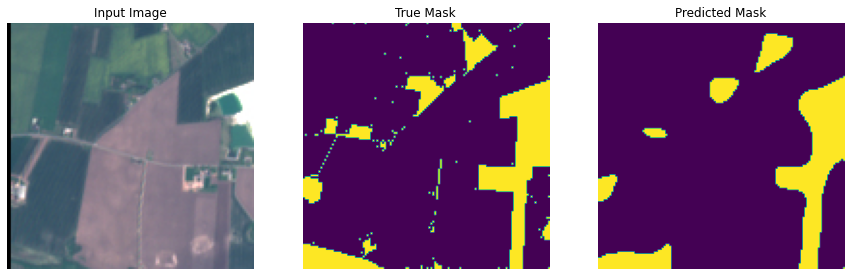

In [11]:
image_num = 6
out = tf.reshape(format_output(model.predict(X[image_num].reshape((1,128,128,3))), display=True), [128,128,1])
picture = (X[image_num].reshape((128,128,3)))
label = (np.argmax(Y[image_num], axis=1).reshape((128,128,1)))
display([picture, label, out])